<img align="right" src="https://raw.githubusercontent.com/dcblum/OpenStreetMap/master/IrvineMapBoundaries.PNG" title="Irvine Map Extract Area">

# OpenStreetMap Case Study with SQL

### Map Area: Irvine, California

City Boundaries:
* https://www.openstreetmap.org/relation/114485

Map Extract Website:
* https://mapzen.com/data/metro-extracts-alt/

The Map Extract data extends beyond Irvine City limits in the shape of a rectangle. For the purpose of this dataset the any data in the given rectangular picture is considered to be in Irvine.

#### Contents
 - [Problems Encountered](#problems-encountered)
     - [Auditing Data](#auditing-data)
     - [Postal Codes](#postal-codes)
     - [City Count](#city-count)
 - [Overview Statistics](#overview-statistics)
     - [File Sizes](#file-sizes)
     - [Number of Nodes](#number-of-nodes)
     - [Number of Ways](#number-of-ways)
     - [Unique Users](#unique-users)
     - [Top 10](#top-ten)
         - [Amenities](#amenities)
         - [Types of Food](#types-of-food)

In [55]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Allow plots to be printed inline in jupyter notebook
%matplotlib inline

# Fetch records from the database
db = sqlite3.connect("IrvineMaps.db")

def execute_query(query):
    '''Executes query in sqlite3'''
    c = db.cursor()
    c.execute(QUERY)
    rows = c.fetchall()
    c.close()
    return pd.DataFrame(rows)

def print_query(df_name, column_names):
    '''prints df in table with given column names'''
    df_name.columns = column_names
    from IPython.display import display, HTML
    display(HTML(df_name.to_html(index=False)))
    
    
def print_graph(df_name, column_names, graph_title):
    '''prints df graph with first two column names and title'''
    sns.barplot(x=df_name[1], y=df_name[0], orient='h', order = df_name[0], palette="Blues_d")
    sns.axlabel(column_names[1], column_names[0])

    plt.title(graph_title)
    plt.show()

 ### Problems Encountered <a name="problems-encountered"></a>

After running the data agaisnt the given data.py file, a few problems were found:
* Inconsistent use of abbreviations: ex. "Rd.", "Rd", and "Road" to all indicate "Road"
* Use of intersection as address: ex. "Avocado Av @ San Joaquin Hills Rd"
* Unicode street and postcode data containing (street = 'Rue Jean Jaur\xe8s' and postcode = '92626\xad)
* Postcode data contaning non-integer characters such as letters and hyphens: ex. "CA 92701" and "92610-3437"

### Auditing Data <a name="auditing-data"></a>

IrvineMaps.db was audited via audit.py to help identify inconsistent use of abbreviations for both Street Names and Postal Codes. The OSM file was not modified; all corrections were made during the creation of the database in data.py. 

Postal codes not of length 5 were audited. It was viewed that splitting based on either a " " or "-" would fix multiple Postal Codes.  There was only ever one item in the split with a length of 5; that item was taken to be the post code.

~~~python
postcode_split = re.split('[ -]', postcode)
for item in postcode_split:
    if len(item) == 5:
        tags['value'] = item
~~~

Street Names ending in expected results were skipped during the the auditing process and were updated via function update_name.

~~~python
def update_name(name, mapping):
    name_split = name.split()
    for e in range(len(name_split)):
        if name_split[e] in mapping:
            name_split[e] = mapping[name_split[e]]
    name = " ".join(name_split)
    return name
~~~

Only Postal Code and Street Data was audited. There are still errors in both data sets which include unicode characters: ex. 'Rue Jean Jaur\xe8s'

### Postal Codes <a name="postal-codes"></a>

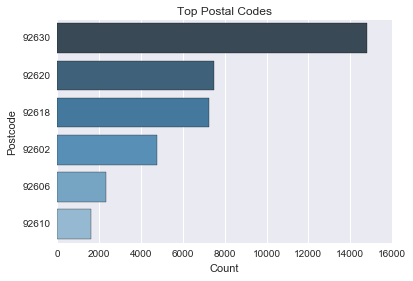

In [56]:
QUERY = ( 
    "SELECT tags.value, COUNT(*) as count "
    "FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags "
    "WHERE tags.key='postcode' "
    "GROUP BY tags.value "
    "ORDER BY count DESC "
    "LIMIT 6;"
    )

#print_query(execute_query(QUERY), ['Postcode', 'Count'])
print_graph(execute_query(QUERY), ['Postcode', 'Count'], "Top Postal Codes")

### City Count <a name="city-count"></a>

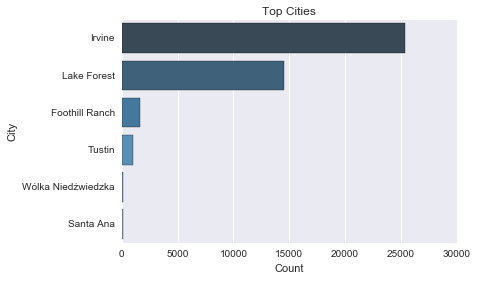

In [57]:
QUERY = ( 
    "SELECT tags.value, COUNT(*) as count "
    "FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags "
    "WHERE tags.key LIKE '%city' "
    "GROUP BY tags.value "
    "ORDER BY count DESC "
    "LIMIT 6;"
    )


print_graph(execute_query(QUERY), ['City', 'Count'], "Top Cities")

# Overview Statistics of the Dataset <a name="overview-statistics"></a>

### File Sizes <a name="file-sizes"></a>
~~~
Irvine.osm .......... 91 MB
IrvineMaps.db ....... 58 MB
nodes.csv ........... 28 MB
nodes_tags.csv ...... 7 MB
ways.csv ............ 3 MB
ways_nodes.csv ...... 10 MB
ways_tags.csv ....... 11 MB
~~~

### Number of Nodes <a name="number-of-nodes"></a>

In [58]:
QUERY = "SELECT COUNT(*) FROM nodes;"

print_query(execute_query(QUERY), ['# of Nodes'])

# of Nodes
345345


### Number of Ways <a name="number-of-ways"></a>

In [59]:
QUERY = "SELECT COUNT(*) FROM ways;"

print_query(execute_query(QUERY), ['# of Ways'])

# of Ways
66056


### Unique Users <a name="unique-users"></a>

In [60]:
QUERY = (
    "SELECT COUNT(DISTINCT(uid)) "
    "FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) uid; "
    )

print_query(execute_query(QUERY), ['Unique Users'])

Unique Users
2008


### Top Ten <a name="top-ten"></a>

##### Amenities <a name="amenities"></a>

In [61]:
QUERY = (
    "SELECT value, COUNT(*) as num "
    "FROM nodes_tags "
    "WHERE key='amenity' "
    "GROUP BY value "
    "ORDER BY num DESC "
    "LIMIT 10;"
    )

print_query(execute_query(QUERY), ['Amenity', 'Count'])

Amenity,Count
restaurant,146
bicycle_parking,53
cafe,50
fast_food,45
school,45
drinking_water,43
place_of_worship,43
bench,35
toilets,27
bank,20


##### Types of Food <a name="types-of-food"></a>

In [62]:
QUERY = (
    "SELECT nodes_tags.value, COUNT(*) as num "
    "FROM nodes_tags "
    "WHERE nodes_tags.key='cuisine' "
    "GROUP BY nodes_tags.value "
    "ORDER BY num DESC "
    "LIMIT 10; "
    )

print_query(execute_query(QUERY), ['Type of Food', 'Count'])

Type of Food,Count
mexican,23
burger,14
coffee_shop,12
sandwich,12
american,11
pizza,11
japanese,8
chinese,6
sushi,6
french,3
